Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.7892 - loss: 0.4146 - val_accuracy: 0.9650 - val_loss: 0.1119
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9697 - loss: 0.0985 - val_accuracy: 0.9670 - val_loss: 0.0892
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9769 - loss: 0.0697 - val_accuracy: 0.9680 - val_loss: 0.0807
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9791 - loss: 0.0611 - val_accuracy: 0.9670 - val_loss: 0.0769
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9815 - loss: 0.0538 - val_accuracy: 0.9690 - val_loss: 0.0765
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9663 - loss: 0.0780

✅ Validation Accuracy: 0.9690
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<ipython-input-7-ad385a87048f>:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_names[int(predictions[i] > 0.5)]


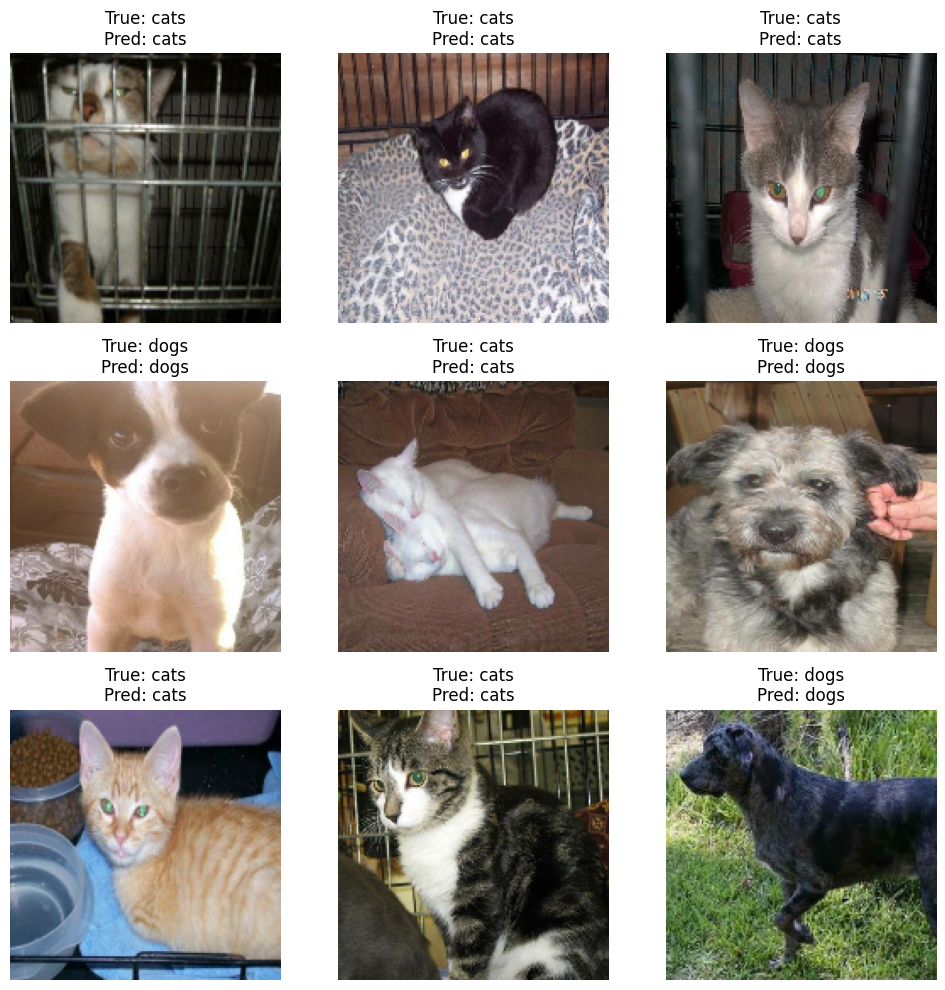

In [7]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Download dataset to /content
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file(fname='cats_and_dogs_filtered.zip',
                                   origin=dataset_url,
                                   extract=False)  # we'll extract manually

# Step 2: Extract zip manually to /content/
local_extract_path = '/content/cats_and_dogs_filtered'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Step 3: Set up paths
train_dir = os.path.join(local_extract_path, 'train')
validation_dir = os.path.join(local_extract_path, 'validation')

# Step 4: Load datasets
batch_size = 32
img_size = (160, 160)

# Load datasets before prefetching to access class_names
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=img_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=batch_size,
                                                                 image_size=img_size)

# Get class names *before* prefetching
class_names = train_dataset.class_names

# Step 5: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Step 6: Load base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_size + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze base

# Step 7: Create classification model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Step 8: Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 9: Train the model
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=5)

# Step 10: Evaluate
loss, acc = model.evaluate(validation_dataset)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

# Step 11: Visualize predictions
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Convert images to uint8 before displaying
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(predictions[i] > 0.5)]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
plt.tight_layout()
plt.show()